<a href="https://colab.research.google.com/github/sinem9051/SlipProje/blob/main/engineeringProject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.0 MB/s eta 0:00:00


In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import shutil
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import gradio as gr

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, EfficientNetB0


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Orijinal dataset yolun
DATASET_PATH = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

filepaths = []
labels = []

# Tüm dosyaları ve etiketleri topla
for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)

# DataFrame oluştur
df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Önce train (%70) ve temp (%30) olarak ayır
train_df, temp_df = train_test_split(df, stratify=df['labels'], test_size=0.3, random_state=42)

# Sonra temp'i validation (%15) ve test (%15) olarak ikiye böl
val_df, test_df = train_test_split(temp_df, stratify=temp_df['labels'], test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 523, Val: 112, Test: 113


In [9]:
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 523
Validation: 112
Test: 113


In [10]:
print("Train distribution:\n", train_df['labels'].value_counts())
print("\nValidation distribution:\n", val_df['labels'].value_counts())
print("\nTest distribution:\n", test_df['labels'].value_counts())


Train distribution:
 labels
benign       297
malignant    140
normal        86
Name: count, dtype: int64

Validation distribution:
 labels
benign       64
malignant    30
normal       18
Name: count, dtype: int64

Test distribution:
 labels
benign       64
malignant    30
normal       19
Name: count, dtype: int64


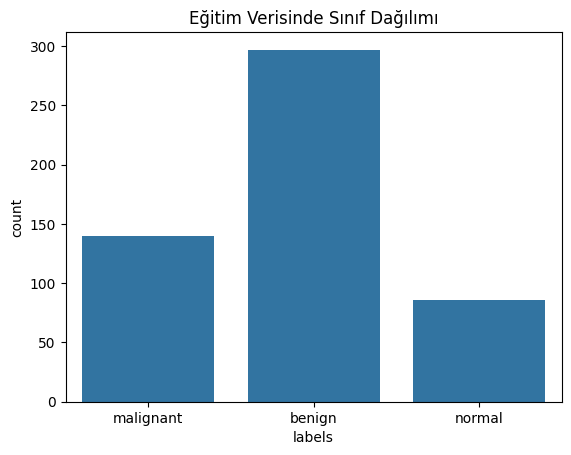

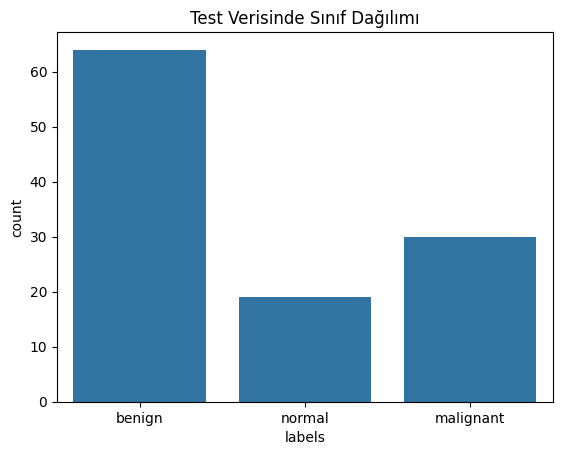

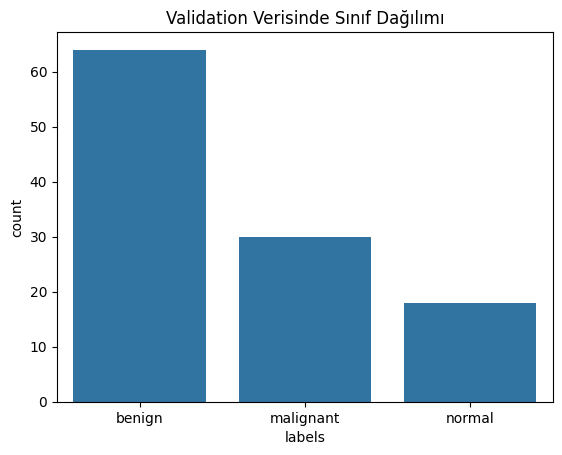

In [13]:
sns.countplot(x='labels', data=train_df)
plt.title("Eğitim Verisinde Sınıf Dağılımı")
plt.show()

sns.countplot(x='labels', data=test_df)
plt.title("Test Verisinde Sınıf Dağılımı")
plt.show()

sns.countplot(x='labels', data=val_df)
plt.title("Validation Verisinde Sınıf Dağılımı")
plt.show()

In [14]:
print(train_df.head())
print(val_df.head())
print(test_df.head())


                                             filepaths     labels
596  /content/drive/MyDrive/Dataset_BUSI_with_GT/ma...  malignant
258  /content/drive/MyDrive/Dataset_BUSI_with_GT/be...     benign
601  /content/drive/MyDrive/Dataset_BUSI_with_GT/ma...  malignant
653  /content/drive/MyDrive/Dataset_BUSI_with_GT/ma...  malignant
155  /content/drive/MyDrive/Dataset_BUSI_with_GT/be...     benign
                                             filepaths     labels
257  /content/drive/MyDrive/Dataset_BUSI_with_GT/be...     benign
344  /content/drive/MyDrive/Dataset_BUSI_with_GT/be...     benign
362  /content/drive/MyDrive/Dataset_BUSI_with_GT/be...     benign
641  /content/drive/MyDrive/Dataset_BUSI_with_GT/ma...  malignant
726  /content/drive/MyDrive/Dataset_BUSI_with_GT/ma...  malignant
                                             filepaths     labels
20   /content/drive/MyDrive/Dataset_BUSI_with_GT/be...     benign
440  /content/drive/MyDrive/Dataset_BUSI_with_GT/no...     normal
627  /cont

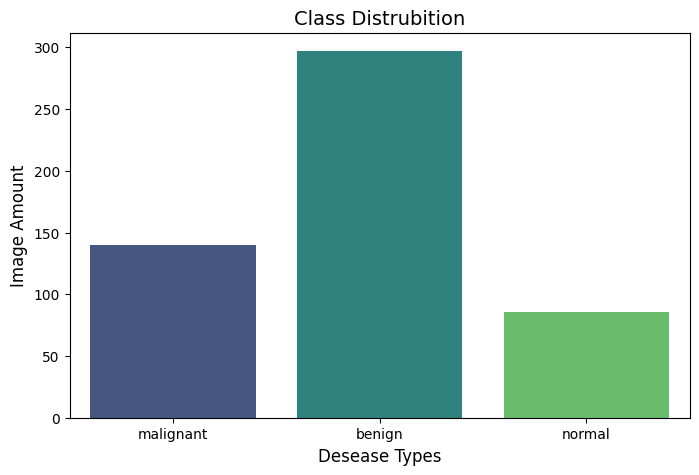

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x=train_df['labels'], palette="viridis")
plt.title("Class Distrubition", fontsize=14)
plt.xlabel("Desease Types", fontsize=12)
plt.ylabel("Image Amount", fontsize=12)
plt.show()


In [16]:
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_effnet

img_size = (224, 224)
batch_size = 16

train_datagen_vgg = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_vgg
)

test_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_vgg)

train_datagen_resnet = ImageDataGenerator(
    # aynı augmentasyonlar, ama preprocess_resnet
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_resnet
)

test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_resnet)

train_datagen_inception = ImageDataGenerator(
    # augmentasyonlar aynı, preprocess_inception
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_inception
)

test_datagen_inception = ImageDataGenerator(preprocessing_function=preprocess_inception)

train_datagen_effnet = ImageDataGenerator(
    # augmentasyonlar aynı, preprocess_effnet
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_effnet
)

test_datagen_effnet = ImageDataGenerator(preprocessing_function=preprocess_effnet)

# Dictionary olarak saklayalım:
train_datagens = {
    'vgg': train_datagen_vgg,
    'resnet': train_datagen_resnet,
    'inception': train_datagen_inception,
    'effnet': train_datagen_effnet
}

test_datagens = {
    'vgg': test_datagen_vgg,
    'resnet': test_datagen_resnet,
    'inception': test_datagen_inception,
    'effnet': test_datagen_effnet
}


In [ ]:
model_name = 'vgg'

train_generator = train_datagens[model_name].flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
val_generator = test_datagens[model_name].flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 523 validated image filenames belonging to 3 classes.
Found 112 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Üstüne kendi katmanlarımızı ekleyelim
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # sınıf sayısı kadar output
])

# Base modelin ağırlıklarını eğitilmeye kapatalım (fine-tuning yapacağız istersen)
base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.6582 - loss: 0.8977 - val_accuracy: 0.7679 - val_loss: 0.5290
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.6517 - loss: 0.7986 - val_accuracy: 0.8214 - val_loss: 0.5120
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 287s 9s/step - accuracy: 0.6750 - loss: 0.7186 - val_accuracy: 0.7946 - val_loss: 0.5031
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.6435 - loss: 0.7907 - val_accuracy: 0.7679 - val_loss: 0.5038
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.6903 - loss: 0.7964 - val_accuracy: 0.7857 - val_loss: 0.4871
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 247s 8s/step - accuracy: 0.7080 - loss: 0.7009 - val_accuracy: 0.7768 - val_loss: 0.5007
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.6880 - loss: 0.7441 - val_accuracy: 0.7768 - val_loss: 0.4708
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.7066 - loss: 0.6469 - val_accuracy: 0.8125 - v

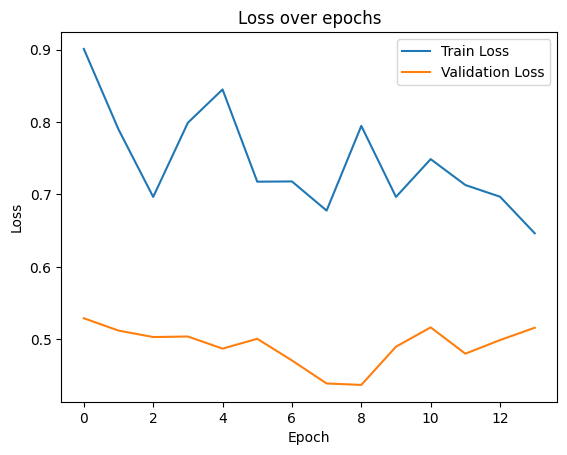

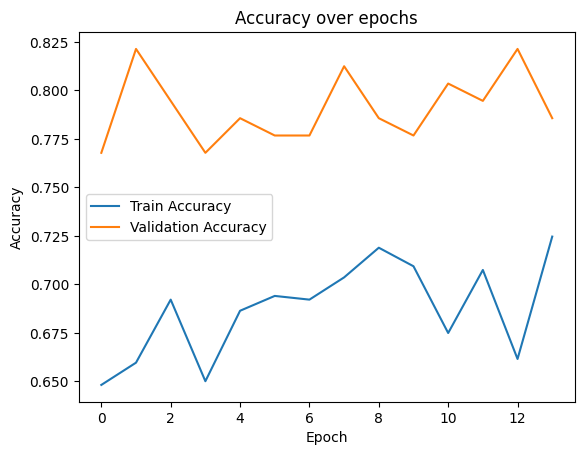

In [ ]:
# Grafik çizimi için matplotlib
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybı
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test generator
test_generator = test_datagens[model_name].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 113 validated image filenames belonging to 3 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Gerçek etiketler
true_labels = test_generator.classes

# Tahminler
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

# Classification Report
target_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=target_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step
Confusion Matrix:
[[56  2  6]
 [11 17  2]
 [ 8  1 10]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.88      0.81        64
   malignant       0.85      0.57      0.68        30
      normal       0.56      0.53      0.54        19

    accuracy                           0.73       113
   macro avg       0.72      0.66      0.68       113
weighted avg       0.74      0.73      0.73       113



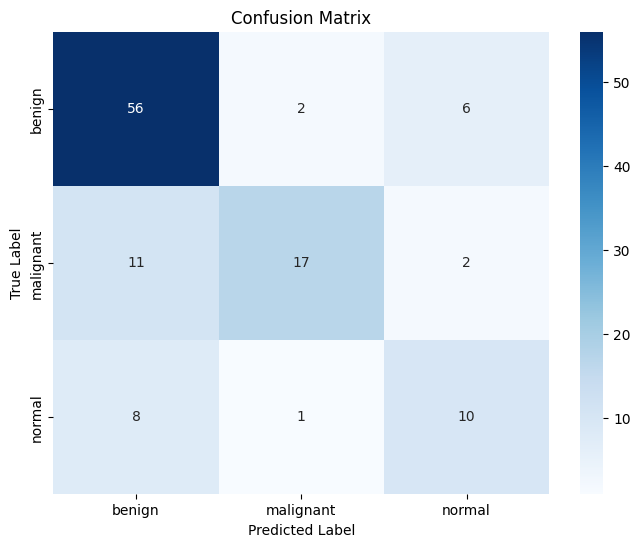

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/breast_cancer_vgg_model.h5")


In [ ]:
model_name = 'inception'
train_generator = train_datagens[model_name].flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagens[model_name].flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 523 validated image filenames belonging to 3 classes.
Found 112 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,911,011 (133.17 MB)

 Trainable params: 13,108,227 (50.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 367s 11s/step - accuracy: 0.4586 - loss: 21.4466 - val_accuracy: 0.7411 - val_loss: 3.2985
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.5731 - loss: 4.1792 - val_accuracy: 0.5625 - val_loss: 0.8486
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.5347 - loss: 0.9588 - val_accuracy: 0.5179 - val_loss: 0.7614
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.5523 - loss: 0.8820 - val_accuracy: 0.7054 - val_loss: 0.6785
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.5986 - loss: 0.9476 - val_accuracy: 0.7054 - val_loss: 0.7562
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.6089 - loss: 0.8951 - val_accuracy: 0.6607 - val_loss: 0.7195
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.6120 - loss: 0.8024 - val_accuracy: 0.6339 - val_loss: 0.7396
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5964 - loss: 0.8451 - val_accuracy: 0.6339 -

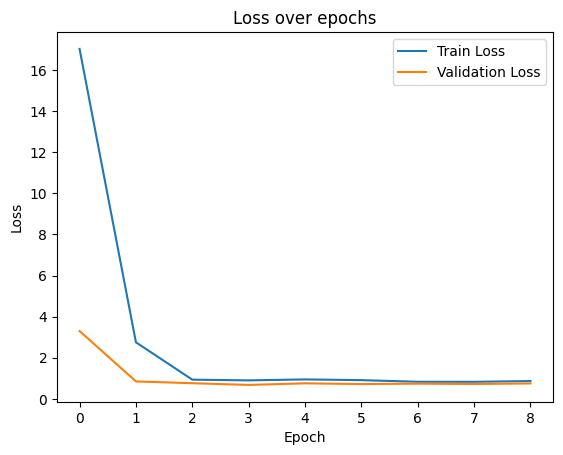

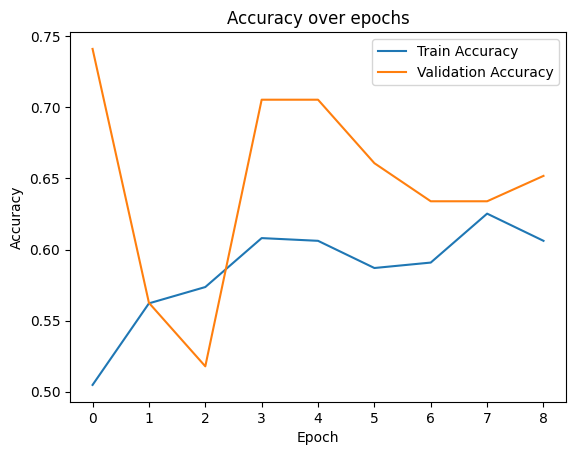

In [ ]:
# Eğitim ve doğrulama kaybı
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_generator = test_datagens[model_name].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 113 validated image filenames belonging to 3 classes.


8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step
Confusion Matrix:
[[55  9  0]
 [20 10  0]
 [12  6  1]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.63      0.86      0.73        64
   malignant       0.40      0.33      0.36        30
      normal       1.00      0.05      0.10        19

    accuracy                           0.58       113
   macro avg       0.68      0.42      0.40       113
weighted avg       0.63      0.58      0.53       113



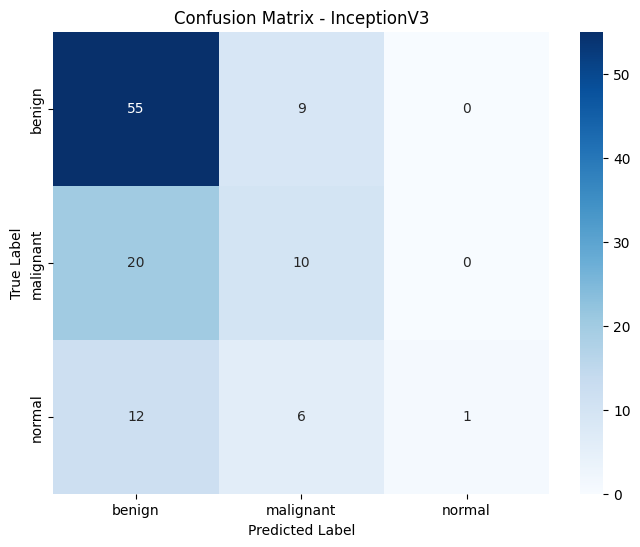

In [ ]:
true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

target_names = list(test_generator.class_indices.keys())

print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=target_names))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - InceptionV3')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/breast_cancer_inception_model.h5")


In [ ]:
model_name = 'resnet'

train_generator = train_datagens[model_name].flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagens[model_name].flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 523 validated image filenames belonging to 3 classes.
Found 112 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Freeze base model
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.4857 - loss: 1.3904 - val_accuracy: 0.6607 - val_loss: 0.8465
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.5711 - loss: 1.0395 - val_accuracy: 0.6875 - val_loss: 0.7771
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.6027 - loss: 0.8726 - val_accuracy: 0.7054 - val_loss: 0.7063
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.6886 - loss: 0.7179 - val_accuracy: 0.6964 - val_loss: 0.6890
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.6707 - loss: 0.7325 - val_accuracy: 0.7679 - val_loss: 0.6066
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.6988 - loss: 0.7439 - val_accuracy: 0.7232 - val_loss: 0.6564
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.7506 - loss: 0.5908 - val_accuracy: 0.7411 - val_loss: 0.6165
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.7201 - loss: 0.5757 - val_accuracy: 0.7232 - v

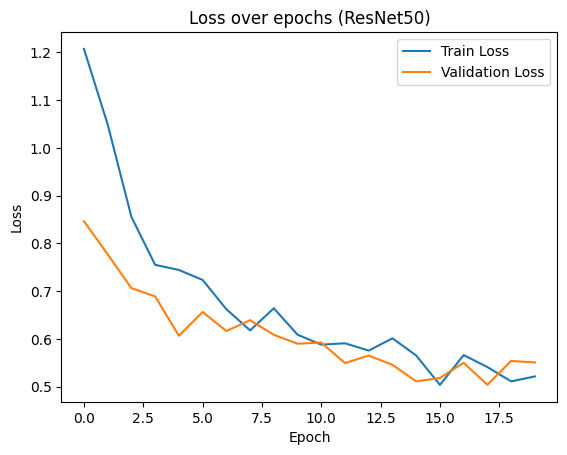

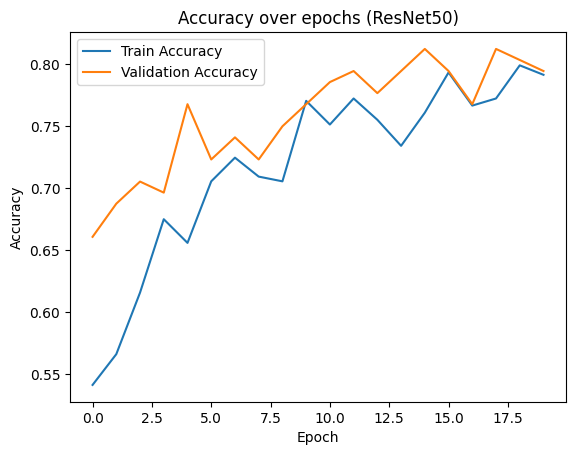

In [ ]:
# Loss Grafiği
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Grafiği
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Found 113 validated image filenames belonging to 3 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
Confusion Matrix:
[[57  6  1]
 [11 19  0]
 [10  3  6]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.73      0.89      0.80        64
   malignant       0.68      0.63      0.66        30
      normal       0.86      0.32      0.46        19

    accuracy                           0.73       113
   macro avg       0.76      0.61      0.64       113
weighted avg       0.74      0.73      0.71       113



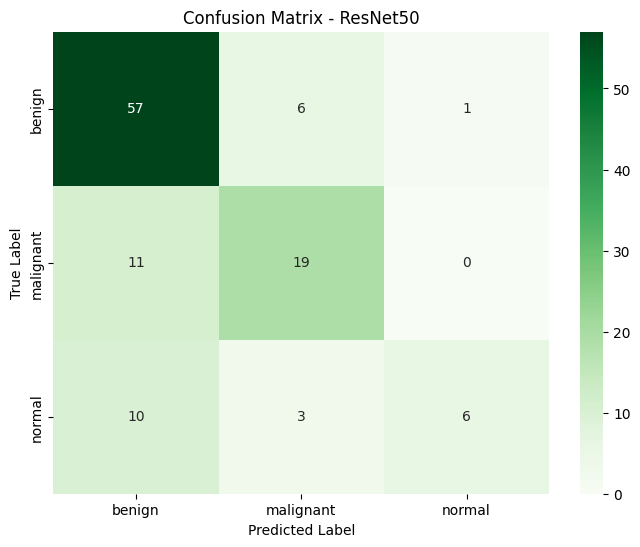

In [ ]:
test_generator = test_datagens[model_name].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

target_names = list(test_generator.class_indices.keys())

print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=target_names))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - ResNet50')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/breast_cancer_resnet50_model.h5")

In [17]:
from tensorflow.keras.models import load_model

vgg_model = load_model('/content/drive/MyDrive/breast_cancer_vgg_model.h5')
inception_model = load_model('/content/drive/MyDrive/breast_cancer_inception_model.h5')
resnet_model = load_model('/content/drive/MyDrive/breast_cancer_resnet50_model.h5')


In [18]:
test_generator = test_datagens['vgg'].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
true_labels = test_generator.classes
target_names = list(test_generator.class_indices.keys())


Found 113 validated image filenames belonging to 3 classes.


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, name):
    pred_probs = model.predict(test_generator)
    pred_labels = np.argmax(pred_probs, axis=1)
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro')
    rec = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

results = []
results.append(evaluate_model(vgg_model, 'VGG16'))
results.append(evaluate_model(inception_model, 'InceptionV3'))
results.append(evaluate_model(resnet_model, 'ResNet50'))

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


3/8 ━━━━━━━━━━━━━━━━━━━━ 49s 10s/step 

KeyboardInterrupt: 

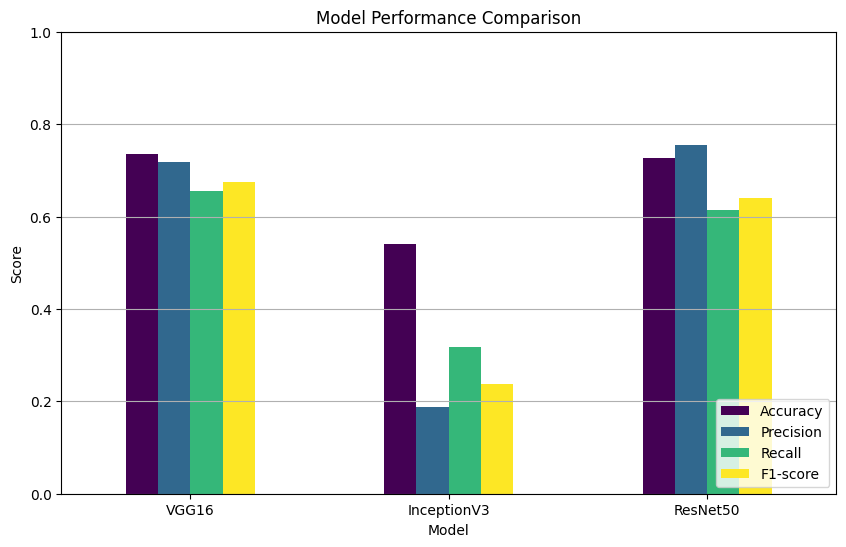

In [ ]:
df_results.set_index('Model').plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step


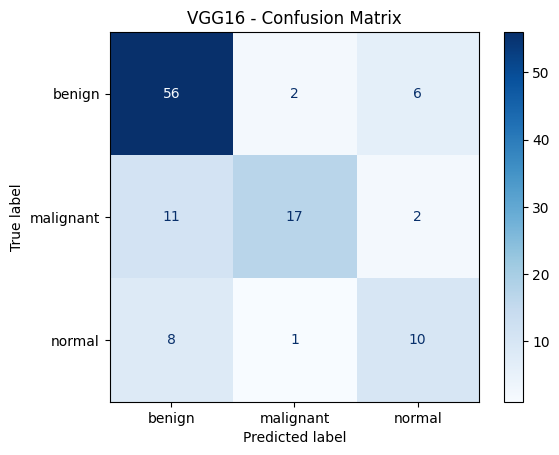

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


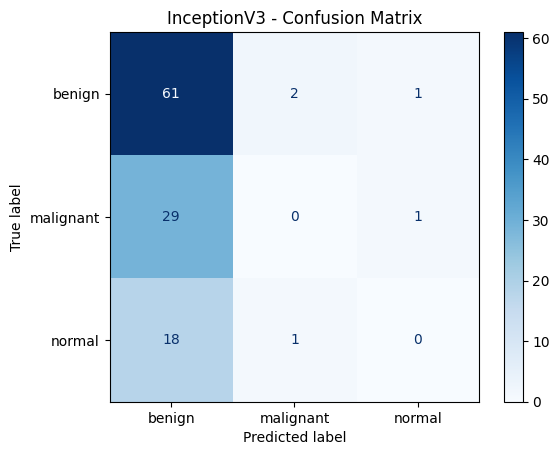

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step


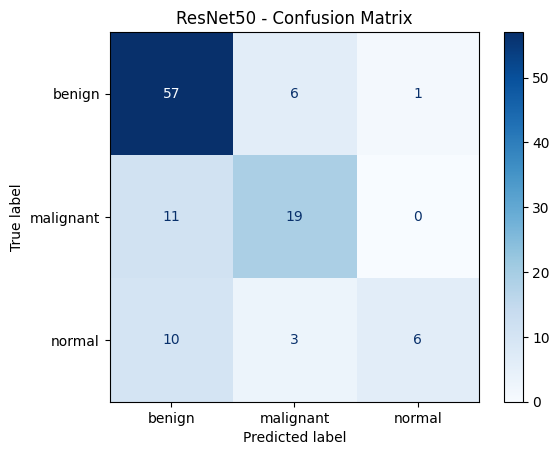

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(model, name):
    pred_probs = model.predict(test_generator)
    pred_labels = np.argmax(pred_probs, axis=1)
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

plot_conf_matrix(vgg_model, "VGG16")
plot_conf_matrix(inception_model, "InceptionV3")
plot_conf_matrix(resnet_model, "ResNet50")


In [ ]:
print("VGG16 params:", vgg_model.count_params())
print("InceptionV3 params:", inception_model.count_params())
print("ResNet50 params:", resnet_model.count_params())


VGG16 params: 21138243
InceptionV3 params: 34911011
ResNet50 params: 24113027


In [ ]:
import os

print("VGG16 size (MB):", os.path.getsize('/content/drive/MyDrive/breast_cancer_vgg_model.h5') / 1e6)
print("InceptionV3 size (MB):", os.path.getsize('/content/drive/MyDrive/breast_cancer_inception_model.h5') / 1e6)
print("ResNet50 size (MB):", os.path.getsize('/content/drive/MyDrive/breast_cancer_resnet50_model.h5') / 1e6)


VGG16 size (MB): 136.02012
InceptionV3 size (MB): 245.137112
ResNet50 size (MB): 101.0578


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
vgg_model = load_model('/content/drive/MyDrive/breast_cancer_vgg_model.h5')
inception_model = load_model('/content/drive/MyDrive/breast_cancer_inception_model.h5')
resnet_model = load_model('/content/drive/MyDrive/breast_cancer_resnet50_model.h5')

In [20]:
# ResNet50
test_generator_resnet = test_datagens['resnet'].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 113 validated image filenames belonging to 3 classes.


In [21]:
# VGG16
test_generator_vgg = test_datagens['vgg'].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 113 validated image filenames belonging to 3 classes.


In [22]:
# InceptionV3 için test generator (categorical)
test_generator_inception = test_datagens['inception'].flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 113 validated image filenames belonging to 3 classes.


In [23]:
# Tahminleri al
vgg_preds = vgg_model.predict(test_generator_vgg, verbose=1)
inception_preds = inception_model.predict(test_generator_inception, verbose=1)
resnet_preds = resnet_model.predict(test_generator_resnet, verbose=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step


In [24]:
import numpy as np
from sklearn.metrics import classification_report

# Gerçek etiketleri al
true_labels = test_generator_vgg.classes  # tüm test generator'lar aynı sırada shuffle=False ile oluşturulduğu için bu yeterli

# Tahminleri sınıfa dönüştür
vgg_pred_labels = np.argmax(vgg_preds, axis=1)
inception_pred_labels = np.argmax(inception_preds, axis=1)
resnet_pred_labels = np.argmax(resnet_preds, axis=1)


In [25]:
vgg_report = classification_report(true_labels, vgg_pred_labels, output_dict=True)
inception_report = classification_report(true_labels, inception_pred_labels, output_dict=True)
resnet_report = classification_report(true_labels, resnet_pred_labels, output_dict=True)



In [ ]:
print(vgg_report.keys())

dict_keys(['0', '1', '2', 'accuracy', 'macro avg', 'weighted avg'])


In [26]:
label_map = test_generator_inception.class_indices
print(label_map)


{'benign': 0, 'malignant': 1, 'normal': 2}


In [27]:
inv_label_map = {v: k for k, v in label_map.items()}

In [28]:
# int etiketleri isimlere çevir
class_names = [inv_label_map[i] for i in sorted(inv_label_map.keys())]

vgg_precisions = [vgg_report[str(i)]['precision'] for i in sorted(inv_label_map.keys())]
inception_precisions = [inception_report[str(i)]['precision'] for i in sorted(inv_label_map.keys())]
resnet_precisions = [resnet_report[str(i)]['precision'] for i in sorted(inv_label_map.keys())]

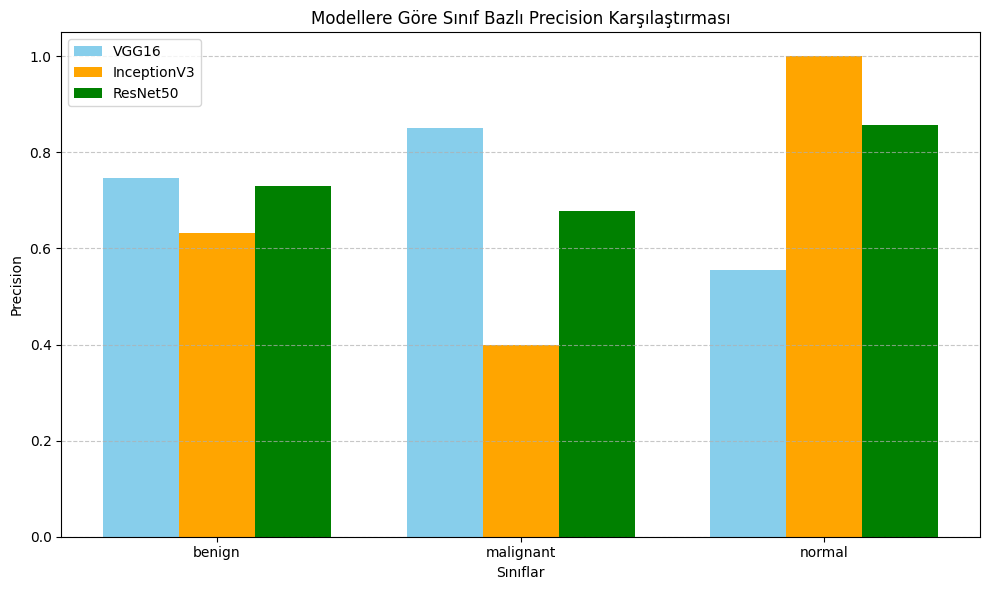

In [29]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(class_names))  # sınıf sayısı kadar x pozisyonu
width = 0.25  # bar genişliği

plt.figure(figsize=(10, 6))

plt.bar(x - width, vgg_precisions, width, label='VGG16', color='skyblue')
plt.bar(x, inception_precisions, width, label='InceptionV3', color='orange')
plt.bar(x + width, resnet_precisions, width, label='ResNet50', color='green')

plt.xlabel('Sınıflar')
plt.ylabel('Precision')
plt.title('Modellere Göre Sınıf Bazlı Precision Karşılaştırması')
plt.xticks(x, class_names)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


RESNET50 ile devam edilecek. Arayüz oluşturulup yüklenen görüntüler predict edilecek.

In [30]:
!pip install gradio --quiet

In [32]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Modeli yükle
model = tf.keras.models.load_model('/content/drive/MyDrive/breast_cancer_inception_model.h5')



# Sınıf isimleri
class_names = ['benign', 'normal', 'malignant']

from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess(image):
    image = image.resize((224, 224))
    image = np.array(image)
    if image.ndim == 2:
        image = np.stack((image,)*3, axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # VGG16 için gerekli!
    return image

def predict(image):
    img = preprocess(image)
    preds = model.predict(img)
    class_idx = np.argmax(preds, axis=1)[0]
    class_label = class_names[class_idx]
    confidence = preds[0][class_idx]
    return f"Tahmin: {class_label} (%{confidence*100:.2f} güven)"


iface = gr.Interface(fn=predict,
                     inputs=gr.Image(type="pil"),
                     outputs="text",
                     title="Breast Cancer Detection",
                     description="Gönderdiğiniz meme ultrason görüntüsünü sınıflandırır: benign, normal veya malignant.")

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a1272e1036184ca08a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
